# Text Analysis

In [1]:
import re
import nltk
import torch
from tqdm import tqdm
from torch import nn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

In [2]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

In [5]:
from tools.text import process_text, total_params, batch_indices

In [6]:
# here you can set which device to use
device = 'cuda' # 'cpu'

## Text Analysis

We're going to bring in some tools from the pure language side such as `nltk`, the natural language toolkit. This let's you easily bring in some public domain works, particularly those from Project Gutenberg..ipynb_checkpoints/lecture_4-checkpoint.ipynb:    "def generate_sequences(vec, l):\n",


In [7]:
# download gutenberg corpus
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /media/wintermute/data/nltk...
[nltk_data]   Package gutenberg is already up-to-date!


True

Let's see what books we get from this particular archive. Some good stuff here. Sense and Sensibility!

In [8]:
# list available books
books = nltk.corpus.gutenberg.fileids()
names = [s.split('.')[0] for s in books]
print(', '.join(names))

austen-emma, austen-persuasion, austen-sense, bible-kjv, blake-poems, bryant-stories, burgess-busterbrown, carroll-alice, chesterton-ball, chesterton-brown, chesterton-thursday, edgeworth-parents, melville-moby_dick, milton-paradise, shakespeare-caesar, shakespeare-hamlet, shakespeare-macbeth, whitman-leaves


It's kind of wonky, but you can read each of these through a file-like object. Let's look at an early paragraph from Moby Dick.

In [9]:
# get text of all books (corpus)
text = [nltk.corpus.gutenberg.open(f).read() for f in books]
print(text[12][117:443])

The pale Usher--threadbare in coat, heart, body, and brain; I see him
now.  He was ever dusting his old lexicons and grammars, with a queer
handkerchief, mockingly embellished with all the gay flags of all the
known nations of the world.  He loved to dust his old grammars; it
somehow mildly reminded him of his mortality.


Now let's look at how long each book is (in terms of characters) and display it as a `DataFrame`.

In [10]:
# get basic info about each text
length = np.array([len(x) for x in text])
info = pd.DataFrame({'name': names, 'length': length})
info

,name,length
0,austen-emma,887071
1,austen-persuasion,466292
2,austen-sense,673022
3,bible-kjv,4332554
4,blake-poems,38153
5,bryant-stories,249439
6,burgess-busterbrown,84663
7,carroll-alice,144395
8,chesterton-ball,457450
9,chesterton-brown,406629


Before using this for anything serious, we're going to want to eliminate any unusual punctuation and merge any whitespace together. Then we're left with something kind of standardized but still readable.

In [11]:
text1 = [process_text(s) for s in text]
print(text1[2][20000:21000])

decision was wanting before , and he finally resolved , that it would be absolutely unnecessary , if not highly indecorous , to do more for the widow and children of his father , than such kind of neighbourly acts as his own wife pointed out .
chapter 3
mrs . dashwood remained at norland several months , not from any disinclination to move when the sight of every well known spot ceased to raise the violent emotion which it produced for a while , for when her spirits began to revive , and her mind became capable of some other exertion than that of heightening its affliction by melancholy remembrances , she was impatient to be gone , and indefatigable in her inquiries for a suitable dwelling in the neighbourhood of norland , for to remove far from that beloved spot was impossible . but she could hear of no situation that at once answered her notions of comfort and ease , and suited the prudence of her eldest daughter , whose steadier judgment rejected several houses as too large for thei

From here we use the `sklearn` tools for text vectorization. The first is a raw count of words, meaning we'll get back a sparse matrix with one row for each book and one column for each word in our vocabulary.

In [12]:
cv = CountVectorizer(stop_words='english')
counts = cv.fit_transform(text1)
nbook, nwrd = counts.shape
counts

<18x41757 sparse matrix of type '<class 'numpy.int64'>'
	with 117238 stored elements in Compressed Sparse Row format>

Note that here we call `fit_transform`, meaning the `fit` part determines our vocabulary from the corpus and the `transform` part actually does the numerical conversion. You may sometimes want to do these separately or to use a pre-existing vocabular instead. There are options for this. The other slightly more advanced alternative is to down-weight each word by its usage frequency in the overall corpus, thus reducing focus on common words such as "the" and "is". This returns a sparse `float` matrix instead.

In [13]:
tfidf = TfidfVectorizer(stop_words='english')
vecs = tfidf.fit_transform(text1)
vecs

<18x41757 sparse matrix of type '<class 'numpy.float64'>'
	with 117238 stored elements in Compressed Sparse Row format>

### Text Similarity

In [14]:
# check that we're really ℓ2 normalized
vecs.power(2).sum(axis=1).getA1()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

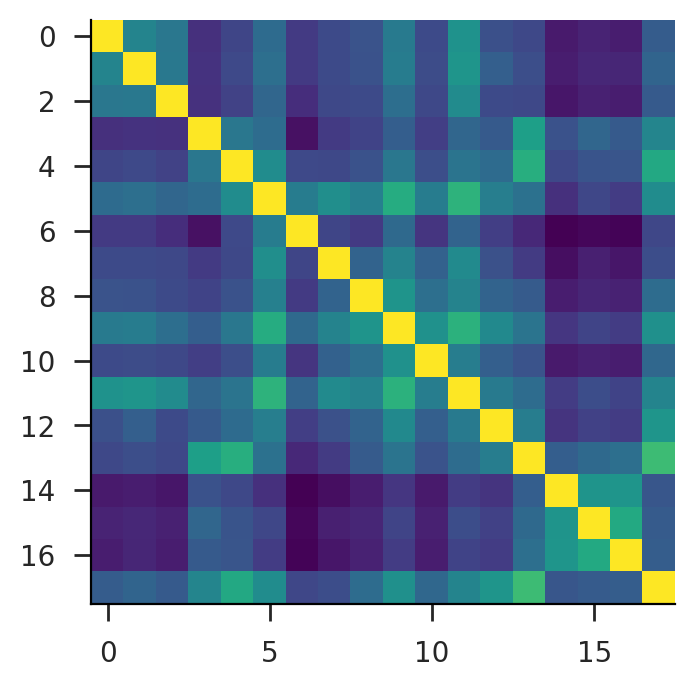

In [15]:
# get the full similarity matrix
sim = (vecs @ vecs.T).todense().getA() # not always feasible for big corpora
plt.imshow(np.sqrt(sim)); # sqrt enhances differences

In [16]:
# get the most commonly used words
all_count = counts.sum(axis=0).getA1()
all_rank = np.argsort(-all_count)
all_words = cv.get_feature_names_out()
print('\n'.join([
    f'{all_words[i]} — {all_count[i]}' for i in all_rank[:20]
]))

shall — 11682
said — 9429
unto — 9010
lord — 8590
thou — 6759
man — 5615
thy — 5609
god — 5287
thee — 4807
ye — 4674
come — 3642
like — 3468
came — 3337
day — 3326
king — 3149
did — 3121
little — 3065
know — 3057
house — 2900
good — 2899


0.8576843343208485


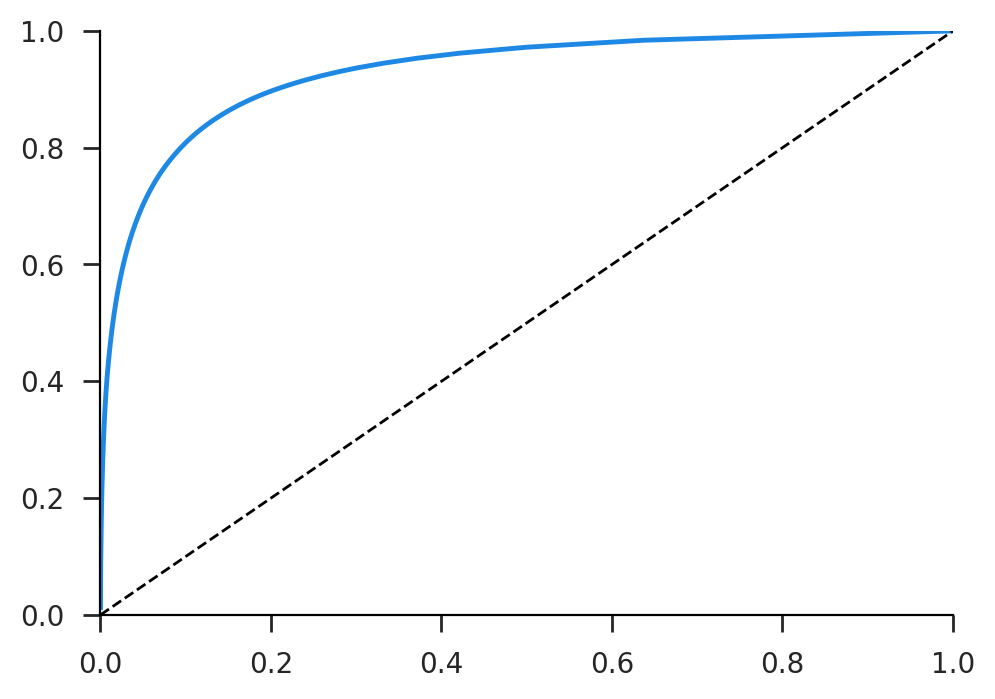

In [17]:
word_cdf = np.cumsum(all_count[all_rank])/np.sum(all_count)
word_gini = 2*(np.sum(word_cdf)/nwrd-0.5)
word_index = np.linspace(0, 1, nwrd)
pd.Series(word_cdf, index=word_index).plot(xlim=(0, 1), ylim=(0, 1))
plt.plot(word_index, word_index, linestyle='--', linewidth=1, c='k')
print(word_gini)

In [18]:
def word_gini(c):
    n = len(c)
    s = -np.sort(-c)
    cdf = np.cumsum(s)/np.sum(c)
    gini = 2*(np.sum(cdf)/n-0.5)
    return gini

In [19]:
ginis = [word_gini(counts[i,:].todense().getA1()) for i in range(nbook)]
info.assign(gini=ginis)

,name,length,gini
0,austen-emma,887071,0.957791
1,austen-persuasion,466292,0.958783
2,austen-sense,673022,0.957912
3,bible-kjv,4332554,0.960545
4,blake-poems,38153,0.984016
5,bryant-stories,249439,0.970558
6,burgess-busterbrown,84663,0.989394
7,carroll-alice,144395,0.980115
8,chesterton-ball,457450,0.932614
9,chesterton-brown,406629,0.934194


### Text Visualization

In [20]:
tsne = TSNE(init='random', perplexity=10)
embed = tsne.fit_transform(vecs)

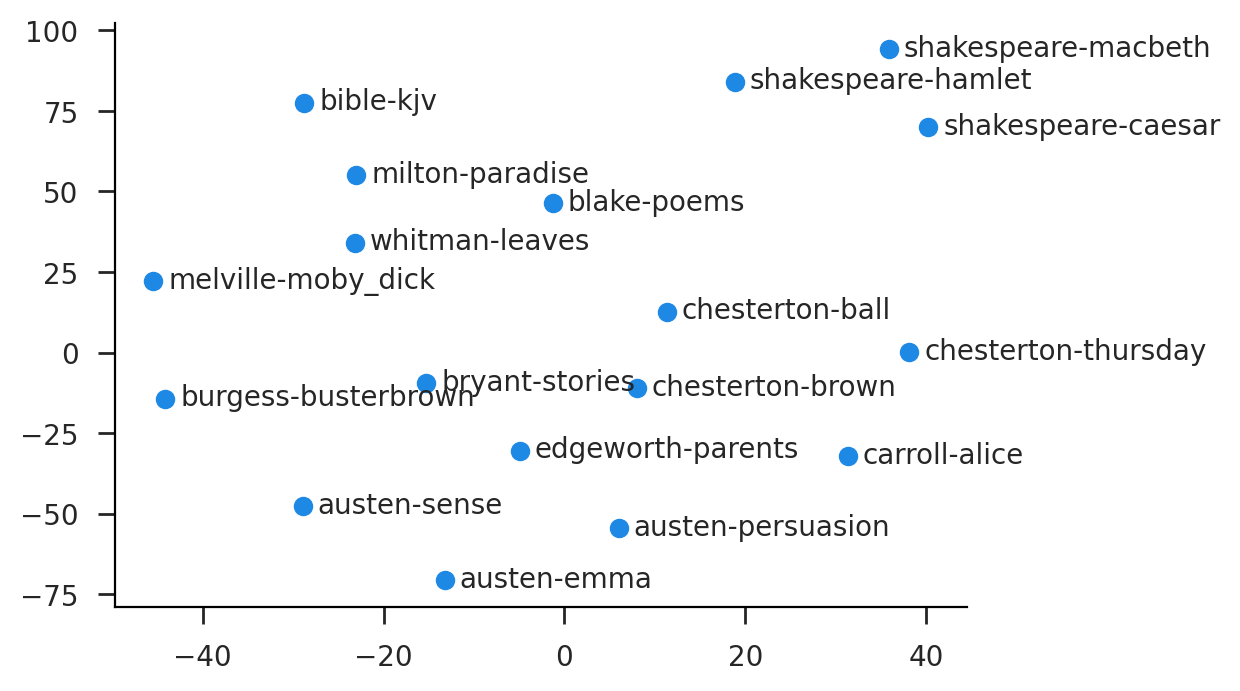

In [21]:
fig, ax = plt.subplots()
ax.scatter(*embed.T)
for i in range(nbook):
    ax.annotate(
        names[i], embed[i], xytext=(15, -7),
        textcoords='offset pixels', fontsize=10
    )

## Embeddings

One issue with using work frequency vectors, however we weight them, is that we won't really be handling synonyms well. Embeddings are just mappings from words or tokens into dense numerical representations, rather than the sparse frequency vectors we've seen so far. These embeddings will (hopefully) map similar words and concepts into similar vectors, meaning we can understand document similarity by looking at the their vector similarity.

Usually you'll be using pre-trained embeddings that have proven accuracy at various tasks, but first let's look at the basic technical construct in `torch`. That would be `nn.Embedding`. This requires two arguments: the size of your vocabulary and the size of the resulting vector. Once created, the embedding is a function (actually it's a class that implements `__call__`) that maps from integer indices into vectors. These indices are just the index of a given word in the vocabulary, so to actually get the embedding for a given word, you have to map from word to index (tokenize) then pass that index to the embedding.

In [22]:
emb = nn.Embedding(1000, 5)
idx = torch.arange(3)
emb(idx)

tensor([[-0.4005, -0.6640, -2.1717, -0.2951, -0.8241],
        [-0.5026,  1.8186, -0.4579, -0.5120,  0.1826],
        [-1.2898, -0.1369,  0.8760, -0.7916,  0.3879]],
       grad_fn=<EmbeddingBackward0>)

The above code creates the embedding then looks at the vectors for the first three indices. Of course, we haven't trained or initialized this embedding in any way, so the numbers are just random. We don't have an associated vocabulary, so this is all pretty abstract. Additionally, we generally don't want to find the embedding for just one word, we want it for an entire string or set of strings.

For this we need to move on to sentence level embeddings. These are typically based on the transformer models that power most large language models today, though they are much smaller in terms of parameter count that LLMs. We'll go over the inner workings of transforms in the next lecture, for now we just need their output. To access these, we'll go through the `sentence_transformers` library from HuggingFace.

In [23]:
mod = SentenceTransformer('TaylorAI/bge-micro-v2').to(device)
print(total_params(mod))
mod

17389824


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [24]:
toks = mod.tokenizer(
    text, max_length=256, padding='max_length', truncation=True,
    return_overflowing_tokens=True, return_tensors='pt'
).to(device)
nchunks, nlen = toks.input_ids.shape
ndim = mod.get_sentence_embedding_dimension()

In [25]:
embeds = torch.zeros(nchunks, ndim, dtype=torch.float)
for i1, i2 in tqdm(batch_indices(nchunks, 16)):
    feats = {
        'input_ids': toks.input_ids[i1:i2,:],
        'attention_mask': toks.attention_mask[i1:i2,:]
    }
    ret = mod.forward(feats)
    embeds[i1:i2,:] = ret['sentence_embedding'].cpu()

  2%|▉                                         | 15/706 [00:00<00:23, 29.09it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 7.78 GiB of which 34.25 MiB is free. Process 2251520 has 168.00 MiB memory in use. Including non-PyTorch memory, this process has 7.08 GiB memory in use. Of the allocated memory 6.67 GiB is allocated by PyTorch, and 277.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF